# Endometrial Proteomics Power Analysis

In [91]:
import pandas as pd
import numpy as np
import scipy.stats
import collections
import re
import gseapy as gp
from gseapy.plot import barplot, dotplot
import matplotlib.pyplot as plt
import seaborn as sns

import cptac
import cptac.algorithms as al


en = cptac.Endometrial()

Checking that index is up-to-date...Loading acetylproteomics data...Loading clinical data...Loading CNA data...Loading definitions data...Loading miRNA data...Loading phosphoproteomics_gene data...Loading phosphoproteomics_site data...Loading proteomics data...Loading somatic_binary data...Loading somatic data...Loading transcriptomics_circular data...Loading transcriptomics_linear data...Formatting dataframes...

### Get Proteomics Data

In [92]:
proteomics = en.get_proteomics()

### Append Clinical Data, Select Histologic Type

In [93]:
all_genes = list(proteomics.columns)
clin_df = en.join_metadata_to_omics(metadata_df_name="clinical", omics_df_name="proteomics", metadata_cols=["Histologic_type"])
clin_df.head()

,Histologic_type,A1BG_proteomics,A2M_proteomics,A2ML1_proteomics,A4GALT_proteomics,AAAS_proteomics,AACS_proteomics,AADAT_proteomics,AAED1_proteomics,AAGAB_proteomics,...,ZSWIM8_proteomics,ZSWIM9_proteomics,ZW10_proteomics,ZWILCH_proteomics,ZWINT_proteomics,ZXDC_proteomics,ZYG11B_proteomics,ZYX_proteomics,ZZEF1_proteomics,ZZZ3_proteomics
Sample_ID,,,,,,,,,,,,,,,,,,,,,
S001,Endometrioid,-1.180,-0.8630,-0.802,0.222,0.2560,0.6650,1.2800,-0.3390,0.412,...,-0.08770,NaN,0.0229,0.1090,NaN,-0.332,-0.43300,-1.020,-0.1230,-0.0859
S002,Endometrioid,-0.685,-1.0700,-0.684,0.984,0.1350,0.3340,1.3000,0.1390,1.330,...,-0.03560,NaN,0.3630,1.0700,0.737,-0.564,-0.00461,-1.130,-0.0757,-0.4730
S003,Endometrioid,-0.528,-1.3200,0.435,NaN,-0.2400,1.0400,-0.0213,-0.0479,0.419,...,0.00112,-0.1450,0.0105,-0.1160,NaN,0.151,-0.07400,-0.540,0.3200,-0.4190
S005,Endometrioid,-1.670,-1.1900,-0.443,0.243,-0.0993,0.7570,0.7400,-0.9290,0.229,...,0.07250,-0.0552,-0.0714,0.0933,0.156,-0.398,-0.07520,-0.797,-0.0301,-0.4670
S006,Serous,-0.374,-0.0206,-0.537,0.311,0.3750,0.0131,-1.1000,NaN,0.565,...,-0.17600,NaN,-1.2200,-0.5620,0.937,-0.646,0.20700,-1.850,-0.1760,0.0513


### Select only 'Endometrioid' Histologic Type

In [94]:
endometrioid_df = clin_df.loc[clin_df['Histologic_type'] == 'Endometrioid']

print(len(endometrioid_df))

endometrioid_df = endometrioid_df.drop("Histologic_type", axis = 1)

endometrioid_df = endometrioid_df.loc[:,~endometrioid_df.columns.duplicated()]


83


### Calculate and store, in a dictionary, the variance for each protein

In [95]:
variance_dict = {}
for protein in endometrioid_df:
    prot_vals = endometrioid_df[protein].dropna()
    variance = np.var(prot_vals)
    #print(variance, "\n")
    if protein not in variance_dict.keys():
        variance_dict[protein] = variance
    else:
        print("REPEAT VAL")

### Print variance for each protein

In [96]:
for key, val in variance_dict.items():
    print(key, ": ", val, "\n")

A1BG_proteomics :  0.34075943433299455 

A2M_proteomics :  0.48049778097671647 

A2ML1_proteomics :  1.5386005044173394 

A4GALT_proteomics :  0.5152592239102392 

AAAS_proteomics :  0.05509122903636611 

AACS_proteomics :  0.29609425130915956 

AADAT_proteomics :  0.3192562878713346 

AAED1_proteomics :  0.21029103914608804 

AAGAB_proteomics :  0.13616536728962111 

AAK1_proteomics :  0.08834805155166206 

AAMDC_proteomics :  0.22184422348013236 

AAMP_proteomics :  0.12428801740185803 

AAR2_proteomics :  0.06227151943977097 

AARS_proteomics :  0.0707222749600813 

AARS2_proteomics :  0.09273350646392077 

AARSD1_proteomics :  0.1933952229257948 

AASDHPPT_proteomics :  0.04756001430631442 

AASS_proteomics :  0.4632990134686311 

AATF_proteomics :  0.11678220727545367 

ABAT_proteomics :  0.5299769976251997 

ABCA8_proteomics :  0.4742329560372743 

ABCB1_proteomics :  0.42242125614794573 

ABCB10_proteomics :  0.23171403681858038 

ABCB6_proteomics :  0.29240627396812313 

ABCB7_

ADGRL4_proteomics :  0.21482122805383602 

ADH1A_proteomics :  1.9521065831416662 

ADH1B_proteomics :  2.6983183184154678 

ADH1C_proteomics :  1.8006856226709242 

ADH4_proteomics :  0.5730086698194802 

ADH5_proteomics :  0.20288230716205544 

ADH6_proteomics :  1.3204180576613584 

ADH7_proteomics :  1.783332202619859 

ADHFE1_proteomics :  0.4032043936000001 

ADI1_proteomics :  0.23255272454266226 

ADIPOQ_proteomics :  1.1738869955697486 

ADIPOR1_proteomics :  0.3037776795555555 

ADIRF_proteomics :  0.9826119907957908 

ADK_proteomics :  0.1338129015577297 

ADM_proteomics :  1.207063238143962 

ADNP_proteomics :  0.0455628907224796 

ADO_proteomics :  0.09786972029748874 

ADPGK_proteomics :  0.09429553918118742 

ADPRH_proteomics :  0.2182922513439396 

ADPRHL2_proteomics :  0.07535881891676584 

ADPRM_proteomics :  0.15746326858223064 

ADRA2A_proteomics :  0.47508132441855994 

ADRM1_proteomics :  0.07637641444891859 

ADSL_proteomics :  0.12541055757584563 

ADSS_proteomi

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0.27924323962460934 

APOBEC3F_proteomics :  0.33133934925083824 

APOBEC3G_proteomics :  0.26480897024822175 

APOBR_proteomics :  0.2503019693647264 

APOC1_proteomics :  1.1486960290710158 

APOC2_proteomics :  0.8448892629532297 

APOC3_proteomics :  0.8001811960099872 

APOC4_proteomics :  0.41674550849456365 

APOD_proteomics :  0.40906981506822476 

APOE_proteomics :  0.5626443062790826 

APOF_proteomics :  0.7179414539580462 

APOH_proteomics :  0.44678917170204685 

APOL1_proteomics :  0.3826058378922919 

APOL2_proteomics :  0.5092683151177658 

APOL3_proteomics :  0.6207480642735925 

APOL6_proteomics :  0.4561474339508929 

APOM_proteomics :  0.42857831800841906 

APOO_proteomics :  0.33033199021103216 

APOOL_proteomics :  0.18722456842969956 

APOPT1_proteomics :  0.1205114356170704 

APP_proteomics :  0.2598476335191755 

APPBP2_proteomics :  0.09763414935086222 

APPL1_proteomics :  0.07708040703094789 

APPL2_proteomics :  0.15725335256754247 

APRT_proteomics :  0.18

ATP6V1C1_proteomics :  0.13502443192602703 

ATP6V1C2_proteomics :  1.133226305894005 

ATP6V1D_proteomics :  0.07125089620020318 

ATP6V1E1_proteomics :  0.09846562551784004 

ATP6V1E2_proteomics :  0.47605184000000006 

ATP6V1F_proteomics :  0.10122810063164467 

ATP6V1G1_proteomics :  0.1708491947280302 

ATP6V1G2_proteomics :  1.0158921194808526 

ATP6V1H_proteomics :  0.058268301519552916 

ATP7A_proteomics :  0.131556535211816 

ATP7B_proteomics :  0.24541698208669407 

ATP8A1_proteomics :  0.2921486357468428 

ATP8B1_proteomics :  0.44761745549716936 

ATP9A_proteomics :  0.33495584958307445 

ATP9B_proteomics :  0.1665057709783841 

ATPAF1_proteomics :  0.17022708265260555 

ATPAF2_proteomics :  0.1486963785643272 

ATR_proteomics : 
BARD1_proteomics :  0.3729096870637118 

BASP1_proteomics :  0.7101849060017711 

BAX_proteomics :  0.14995859669824357 

BAZ1A_proteomics :  0.08466175906259252 

BAZ1B_proteomics :  0.13963581610465967 

BAZ2A_proteomics :  0.07734637900801278 



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.11820360144935402 

CASP9_proteomics :  0.11091788736371026 

CAST_proteomics :  0.2571449771855422 

CASTOR1_proteomics :  0.1630203974140592 

CASTOR2_proteomics :  0.2583027282286988 

CASZ1_proteomics :  0.13576882883408334 

CAT_proteomics :  0.29938669019596453 

CAV1_proteomics :  1.067134540592248 

CAV2_proteomics :  0.6274564991138629 

CAVIN1_proteomics :  0.9949351331310784 

CAVIN2_proteomics :  1.013811407249238 

CAVIN3_proteomics :  0.6014360131978519 

CBFA2T2_proteomics :  0.14441374753671926 

CBFB_proteomics :  0.08946474120772245 

CBL_proteomics :  0.07168162259221944 

CBLB_proteomics :  0.12971691059666132 

CBLC_proteomics :  0.24764914616508527 

CBLL1_proteomics :  0.05907446098815504 

CBLN1_proteomics :  0.060614222222222215 

CBR1_proteomics :  0.4566355442039842 

CBR3_proteomics :  0.40348707858966454 

CBR4_proteomics :  0.35378709059660307 

CBS_proteomics :  1.4373418963374671 

CBWD1_proteomics :  0.101787465876 

CBWD2_proteomics :  0.209275965153


CHMP1A_proteomics :  0.11263396682548989 

CHMP1B_proteomics :  0.09896918489298882 

CHMP2A_proteomics :  0.12850268028123096 

CHMP2B_proteomics :  0.09297088325632166 

CHMP3_proteomics :  0.16728689426331836 

CHMP4A_proteomics :  0.18074775828668194 

CHMP4B_proteomics :  0.0816497060538249 

CHMP4C_proteomics :  0.23478105156045864 

CHMP5_proteomics :  0.0654571524429961 

CHMP6_proteomics :  0.13301621056829727 

CHMP7_proteomics :  0.051570059995267814 

CHN1_proteomics :  0.3055285022048724 

CHN2_proteomics :  0.6013797206869499 

CHORDC1_proteomics :  0.18128464926614493 

CHP1_proteomics :  0.20838158663675427 

CHPF_proteomics :  0.21798956698214536 

CHPF2_proteomics :  0.19596274618737117 

CHRAC1_proteomics :  0.1369160024131561 

CHRD_proteomics :  0.2550043269510192 

CHRDL1_proteomics :  0.9938448771026471 

CHRDL2_proteomics :  1.4893958315903673  

CLPP_proteomics :  0.1335323981725362 

CLPTM1_proteomics :  0.3446941642938016 

CLPTM1L_proteomics :  0.2331692074

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 :  3.245784683446712 

DDX46_proteomics :  0.04293459677006824 

DDX47_proteomics :  0.14077093143895805 

DDX49_proteomics :  0.23987661817680353 

DDX5_proteomics :  0.061286565811841776 

DDX50_proteomics :  0.06662816107478589 

DDX51_proteomics :  0.0516192864276673 

DDX52_proteomics :  0.08856046625620004 

DDX54_proteomics :  0.15151780643634782 

DDX55_proteomics :  0.08386304514745242 

DDX56_proteomics :  0.07097570656896501 

DDX58_proteomics :  0.16982540754277134 

DDX59_proteomics :  0.12088049171273037 

DDX6_proteomics :  0.038271497556056314 

DDX60_proteomics :  0.21923458596230705 

DDX60L_proteomics :  0.17435199961183995 

DEAF1_proteomics :  0.30550067894920624 

DECR1_proteomics :  0.2493024815573523 

DECR2_proteomics :  0.22090629854199448 

DEDD_proteomics :  0.17592624930283932 

DEF6_proteomics :  0.2131695391337666 

DEF8_proteomics :  0.16214605599960935 

DEFA1B_proteomics :  3.153504051669483 

DEFA3_proteomics :  5.211855324897661 

DEFA4_proteomics :

EIF3C_proteomics :  0.04212033254057918 

EIF3D_proteomics :  0.035807190106227314 

EIF3E_proteomics :  0.032377940796002896 

EIF3F_proteomics :  0.05125852698681808 

EIF3G_proteomics :  0.055989868244767 

EIF3H_proteomics :  0.04053605840235156 

EIF3I_proteomics :  0.05489783365428946 

EIF3J_proteomics :  0.0695288881685295 

EIF3K_proteomics :  0.07872233936876182 

EIF3L_proteomics :  0.028301236223080284 

EIF3M_proteomics :  0.049779848834605886 

EIF4A1_proteomics :  0.3732121439318335 

EIF4A2_proteomics :  0.2656560655247496 

EIF4A3_proteomics :  0.03719806951163176 

EIF4B_proteomics :  0.057774650177297146 

EIF4E_proteomics :  0.06493715318777762 

EIF4E2_proteomics :  0.05040331314060096 

EIF4E3_proteomics :  0.28492520549142125 

EIF4EBP1_proteomics :  0.10724399792640442 

EIF4EBP2_proteomics :  0.08702356723228337 

EIF4EBP3_proteomics :  0.2977543633487289 

EIF4ENIF1_proteomics :  0.0314894300248265 

EIF4G1_proteomics :  0.06482176842235696 

EIF4G2_proteomics

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)





GLB1L_proteomics :  0.24375831784442975 

GLB1L2_proteomics :  0.25979076186764205 

GLCCI1_proteomics :  0.1860160441201341 

GLCE_proteomics :  0.38764474662145443 

GLDC_proteomics :  1.2050192383268246 

GLE1_proteomics :  0.04787984120142255 

GLG1_proteomics :  0.4321101384321672 

GLIPR1_proteomics :  0.4987224993826953 

GLIPR2_proteomics :  0.34789854962470596 

GLIS3_proteomics :  0.23517180159763315 

GLMN_proteomics :  0.08009600320095805 

GLMP_proteomics :  0.2944545196235156 

GLO1_proteomics :  0.13952674343515753 

GLOD4_proteomics :  0.1246983946548992 

GLOD5_proteomics :  0.8679471458024692 

GLRX_proteomics :  0.6589476144750473 

GLRX2_proteomics :  0.2074739957344671 

GLRX3_proteomics :  0.14090552068515022 

GLRX5_proteomics :  0.0822667421948033 

GLS_proteomics :  0.25761287259108734 

GLT8D1_proteomics :  0.32766587326929886 

GLT8D2_proteomics :  0.19004884662222224 

GLTP_proteomics :  0.2229555100397445 

GLUD1_proteomics :  0.29377464223649297 

GLUD2_

HM13_proteomics :  0.549042877458441 

HMBOX1_proteomics :  0.1378455619649587 

HMBS_proteomics :  0.11606502138295834 

HMCES_proteomics :  0.05992563880243985 

HMCN1_proteomics :  0.45531030761959634 

HMG20A_proteomics :  0.09634887308605024 

HMG20B_proteomics :  0.05180385252271737 

HMGA1_proteomics :  0.7818873286178255 

HMGA2_proteomics :  1.0587334406798667 

HMGB1_proteomics :  0.10407842087015122 

HMGB2_proteomics :  0.21218961138626793 

HMGB3_proteomics :  0.3290475108439831 

HMGCL_proteomics :  0.2449903373493976 

HMGCR_proteomics :  0.4349495807519234 

HMGCS1_proteomics :  0.33535799646973424 

HMGCS2_proteomics :  1.9086287643950204 

HMGN1_proteomics :  0.14456766324357676 

HMGN2_proteomics :  0.571796205356394 

HMGN3_proteomics :  0.49380610875018127 

HMGN4_proteomics :  0.42610812626369576 

HMGN5_proteomics :  0.36654530763608645 

HMGXB4_proteomics :  0.06984832202952532 

HMMR_proteomics :  0.3168707298437501 

HMOX1_proteomics :  0.26278287457384225 

H

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)





KIZ_proteomics :  0.2982115861025315 

KLC1_proteomics :  0.06350330194710407 

KLC2_proteomics :  0.0829419873856673 

KLC3_proteomics :  0.48579521731422337 

KLC4_proteomics :  0.07186783435932644 

KLF12_proteomics :  0.16166312666666668 

KLF13_proteomics :  0.15510575381913194 

KLF16_proteomics :  0.2745816370262388 

KLF3_proteomics :  0.13162136322357382 

KLF4_proteomics :  0.8263477581883124 

KLF5_proteomics :  0.19861067402987376 

KLF6_proteomics :  0.2881613915249433 

KLHDC10_proteomics :  0.17278237867739976 

KLHDC2_proteomics :  0.061226313894237175 

KLHDC3_proteomics :  0.15754961094582703 

KLHDC4_proteomics :  0.13215562034826533 

KLHDC7A_proteomics :  0.5012888771048613 

KLHDC8B_proteomics :  0.2158184619979189 

KLHDC9_proteomics :  0.16983395380177516 

KLHL11_proteomics :  0.0794071778749601 

KLHL12_proteomics :  0.33375223648919516 

KLHL13_proteomics :  0.3456890551633038 

KLHL14_proteomics :  0.1740271153120337 

KLHL20_proteomics :  0.05633058060388

LZTS3_proteomics :  0.21035905401853505 

M6PR_proteomics :  0.5207395224386704 

MACC1_proteomics :  0.35045773404100017 

MACF1_proteomics :  0.11124840165086364 

MACO1_proteomics :  0.11384691020605492 

MACROD1_proteomics :  0.34022856822760916 

MACROD2_proteomics :  0.6686548748717086 

MAD1L1_proteomics :  0.03175686809835971 

MAD2L1_proteomics :  0.2642444506982146 

MAD2L1BP_proteomics :  0.09655603097111336 

MAD2L2_proteomics :  0.17559067102040818 

MADD_proteomics :  0.056615833184613155 

MAEA_proteomics :  0.056464290178081 

MAF1_proteomics :  0.11649437190173309 

MAFB_proteomics :  0.31864196166502307 

MAFF_proteomics :  0.29446431235783427 

MAFG_proteomics :  0.09728160851211072 

MAFK_proteomics :  0.32336484505042995 

MAGEA10_proteomics :  2.4463615123705624 

MAGEA4_proteomics :  2.4689431222857143 

MAGEA9B_proteomics :  2.323602830612245 

MAGED1_proteomics :  0.14302033347757295 

MAGED2_proteomics :  0.12743981323803166 

MAGED4_proteomics :  0.2929231236

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.37096100726843095 

MYL6_proteomics :  0.5407690590345187 

MYL6B_proteomics :  0.12978965184099292 

MYL7_proteomics :  0.6276697486218836 

MYL9_proteomics :  1.418477687136014 

MYLK_proteomics :  1.224875726110727 

MYLK3_proteomics :  1.8784888981656847 

MYO10_proteomics :  0.15691103903448977 

MYO18A_proteomics :  0.10395116586717697 

MYO19_proteomics :  0.14360067838922924 

MYO1A_proteomics :  1.2659548377777778 

MYO1B_proteomics :  0.2800954759326462 

MYO1C_proteomics :  0.2931684376774568 

MYO1D_proteomics :  0.2502236380706634 

MYO1E_proteomics :  0.08650606333396894 

MYO1F_proteomics :  0.3238702331998258 

MYO1G_proteomics :  0.26781015866163443 

MYO1H_proteomics :  0.4439114864585033 

MYO5A_proteomics :  0.2682701770778923 

MYO5B_proteomics :  0.18511775938092606 

MYO5C_proteomics :  0.22484371484685728 

MYO6_proteomics :  0.20517545028378567 

MYO9A_proteomics :  0.0805261816771084 

MYO9B_proteomics :  0.0783527520307737 

MYOC_proteomics :  1.39338901680

NSUN2_proteomics :  0.0523303784440993 

NSUN3_proteomics :  0.18303855812646488 

NSUN4_proteomics :  0.12834099932678183 

NSUN5_proteomics :  0.051907559756103935 

NSUN6_proteomics :  0.08501661381863838 

NT5C_proteomics :  0.1922061600555378 

NT5C2_proteomics :  0.15536118219913747 

NT5C3A_proteomics :  0.2651996605446655 

NT5C3B_proteomics :  0.10445123957476876 

NT5DC1_proteomics :  0.19103052891354333 

NT5DC2_proteomics :  0.23388811179941943 

NT5DC3_proteomics :  0.2210871793688779 

NT5E_proteomics :  1.255307586894789 

NTAN1_proteomics :  0.06377383785071856 

NTHL1_proteomics :  0.2053225573759907 

NTM_proteomics :  0.31679396742493754 

NTMT1_proteomics :  0.15212989390480475 

NTN1_proteomics :  0.6551172461426623 

NTN4_proteomics :  0.48424777600104507 

NTPCR_proteomics :  0.34925505161631587 

NTS_proteomics :  0.7383529090330581 

NUB1_proteomics :  0.06463862287616462 

NUBP1_proteomics :  0.11100229196652639 

NUBP2_proteomics :  0.11745416098978083 

NUBP

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0.09544227867642445 

PLEKHG4B_proteomics :  0.2219162350234376 

PLEKHH3_proteomics :  0.2729833759277344 

PLEKHJ1_proteomics :  0.1862251822562358 

PLEKHM1_proteomics :  0.2550316902509374 

PLEKHM2_proteomics :  0.040647547598581225 

PLEKHO1_proteomics :  0.20204569253883006 

PLEKHO2_proteomics :  0.2384892063021048 

PLEKHS1_proteomics :  0.9443984300653223 

PLG_proteomics :  0.5597806122118159 

PLGRKT_proteomics :  0.39208561516330387 

PLIN2_proteomics :  0.542373326883118 

PLIN3_proteomics :  0.16157046436710695 

PLIN4_proteomics :  1.6269021865553783 

PLK1_proteomics :  0.3283429143375525 

PLLP_proteomics :  0.5355510004359375 

PLN_proteomics :  1.0633342499999998 

PLOD1_proteomics :  0.20771876010082738 

PLOD2_proteomics :  0.46847562842697055 

PLOD3_proteomics :  0.16083782743208008 

PLP2_proteomics :  0.2824566396819157 

PLPBP_proteomics :  0.08180229902392219 

PLPP1_proteomics :  0.6552075080478396 

PLPP2_proteomics :  0.8594541638418058 

PLPP3_proteomic

PSMC3_proteomics :  0.03698562533566554 

PSMC3IP_proteomics :  0.9019553530929844 

PSMC4_proteomics :  0.03445411589217595 

PSMC5_proteomics :  0.044884587654347795 

PSMC6_proteomics :  0.02902247674571752 

PSMD1_proteomics :  0.024616255783800264 

PSMD10_proteomics :  0.12612141297224566 

PSMD11_proteomics :  0.03240509740609666 

PSMD12_proteomics :  0.07881099305829581 

PSMD13_proteomics :  0.05328222255144027 

PSMD14_proteomics :  0.05418629165327333 

PSMD2_proteomics :  0.03399239299753228 

PSMD3_proteomics :  0.03487608945127013 

PSMD4_proteomics :  0.07426718392800118 

PSMD5_proteomics :  0.07041318775987804 

PSMD6_proteomics :  0.024834568373958494 

PSMD7_proteomics :  0.0520069054878502 

PSMD8_proteomics :  0.11437358055180723 

PSMD9_proteomics :  0.07962292902260851 

PSME1_proteomics :  0.15959502616902302 

PSME2_proteomics :  0.2667860497650167 

PSME3_proteomics :  0.10503856739936125 

 

PUM3_proteomics :  0.08287943427800844 

PURA_proteomics :  0.2447

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




RPL36A_proteomics :  0.4455463886514735 

RPL36AL_proteomics :  0.4071382454074902 

RPL37_proteomics :  0.4636540849786324 

RPL37A_proteomics :  0.16214482439936134 

RPL38_proteomics :  0.27258118402982756 

RPL39_proteomics :  0.9684980578420571 

RPL4_proteomics :  0.30136225002746403 

RPL5_proteomics :  0.07507061471694007 

RPL6_proteomics :  0.444331517646567 

RPL7_proteomics :  0.30549381671650444 

RPL7A_proteomics :  0.2231791258092612 

RPL7L1_proteomics :  0.19262611606808422 

RPL8_proteomics :  0.2829098651486163 

RPL9_proteomics :  0.04753174463617232 

RPLP0_proteomics :  0.0488110187578168 

RPLP1_proteomics :  0.18782695347211495 

RPLP2_proteomics :  0.0601276932729692 

RPN1_proteomics :  0.5727776821503557 

RPN2_proteomics :  0.5448669322803311 

RPP14_proteomics :  0.07974680265347653 

RPP21_proteomics :  0.34207429814698187 

RPP25_proteomics :  0.18425527532657396 

RPP25L_proteomics :  0.2114551472533889 

RPP30_proteomics :  0.08723026948293831 

RPP38_

SF3A3_proteomics :  0.03487789063960198 

SF3B1_proteomics :  0.04311522153763973 

SF3B2_proteomics :  0.032802387259560466 

SF3B3_proteomics :  0.02167765259637103 

SF3B4_proteomics :  0.10660333548616636 

SF3B5_proteomics :  0.099455802989055 

SF3B6_proteomics :  0.037994651833357526 

SFMBT1_proteomics :  0.14420155220104572 

SFN_proteomics :  0.688259664328705 

SFPQ_proteomics :  0.03572823169063725 

SFR1_proteomics :  0.1215356352193136 

SFRP1_proteomics :  0.906372890003803 

SFRP2_proteomics :  1.4022576005151233 

SFRP4_proteomics :  1.5446978423147333 

SFSWAP_proteomics :  0.045769577150355914 

SFT2D2_proteomics :  0.61114528959375 

SFT2D3_proteomics :  0.5226592671055014 

SFTA2_proteomics :  0.9477902861937717 

SFTPB_proteomics :  0.5368739540860832 

SIGLEC14_proteomics :  0.14198018674829932 

SIGLEC5_proteomics :  0.17935507395061728 

SIGLEC7_proteomics :  0.746922850926222 

SIGMAR1_proteomics :  0.7072001000184012 

SIK2_proteomics :  0.13752667779193795 


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.11374204171287552 

STK25_proteomics :  0.07808927395077572 

STK26_proteomics :  0.46893987302579776 

STK3_proteomics :  0.11961460575058791 

STK32C_proteomics :  0.5685240591165226 

STK33_proteomics :  0.7468590276934242 

STK35_proteomics :  0.2608357251310205 

STK36_proteomics :  0.196733963042693 

STK38_proteomics :  0.0843894518914211 

STK38L_proteomics :  0.0954462909512266 

STK39_proteomics :  0.2505473413151401 

STK4_proteomics :  0.11131083451511102 

STMN1_proteomics :  0.33631088456368124 

STMN2_proteomics :  0.5419597721901873 

STMN3_proteomics :  0.31690298578407605 

STMN4_proteomics :  3.158499714395918 

STMP1_proteomics :  0.15686997767500002 

STN1_proteomics :  0.09230139533775476 

STOM_proteomics :  0.608959765224445 

STOML1_proteomics :  0.12425492729307479 

STOML2_proteomics :  0.18244653140290315 

STON1_proteomics :  0.5940351557447816 

STON2_proteomics :  0.19426811405011674 

STRA6_proteomics :  1.1555878347858912 

STRADA_proteomics :  0.0426

TKT_proteomics :  0.33818740336768754 

TKTL1_proteomics :  0.7393186742067451 

TKTL2_proteomics :  0.44522624894179136 

TLDC1_proteomics :  0.11987027069261143 

TLE1_proteomics :  0.17873059242456085 

TLE2_proteomics :  0.19981215826193222 

TLE3_proteomics :  0.15184707833912042 

TLE4_proteomics :  0.5596656352012759 

TLK1_proteomics :  0.06962413359451415 

TLK2_proteomics :  0.06820565712727535 

TLN1_proteomics :  0.33156297857689093 

TLN2_proteomics :  0.23175762307446657 

TLNRD1_proteomics :  0.40638000830028964 

TLR2_proteomics :  0.3064745111944638 

TLR3_proteomics :  0.3759718103040789 

TM2D1_proteomics :  0.6137379403483395 

TM2D3_proteomics :  0.3427144824597633 

TM4SF1_proteomics :  0.5386018734486065 

TM7SF2_proteomics :  0.6179818733457265 

TM7SF3_proteomics :  0.2701473494307375 

TM9SF1_proteomics :  0.29095724719593546 

TM9SF2_proteomics :  0.46384545006241823 

TM9SF3_proteomics :  0.5978253695093336 

TM9SF4_proteomics :  0.3671720598101031 

TMA16_p

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 :  1.2011808778922919 

WFS1_proteomics :  0.5040594839243141 

WHAMM_proteomics :  0.187229338016 

WIF1_proteomics :  3.014418816970821 

WIPF1_proteomics :  0.21341358999108717 

WIPF2_proteomics :  0.06827155176023401 

WIPF3_proteomics :  0.5408372410737343 

WIPI1_proteomics :  0.24254508116707785 

WIPI2_proteomics :  0.08313439522418349 

WISP2_proteomics :  0.5908834390600958 

WIZ_proteomics :  0.05854804311928116 

WLS_proteomics :  0.6322201220758892 

WNK1_proteomics :  0.0498933530187229 

WNK2_proteomics :  0.31901207313581076 

WNT11_proteomics :  0.647812936 

WNT2_proteomics :  0.5130642289668748 

WNT2B_proteomics :  1.2081815222633134 

WNT4_proteomics :  0.7232206404816325 

WNT5A_proteomics :  0.3841889741356656 

WNT5B_proteomics :  0.378060419456 

WNT7A_proteomics :  1.3064151684386582 

WRAP53_proteomics :  0.10928626186314419 

WRAP73_proteomics :  0.25673712258585096 

WRB_proteomics :  0.34072738585386414 

WRB-SH3BGR_proteomics :  0.5477393649597359 

WRN

ZSCAN12_proteomics :  0.5774688950692521 

ZSCAN18_proteomics :  0.22430812450622736 

ZSCAN2_proteomics :  0.3333409140998027 

ZSCAN21_proteomics :  0.08617080358670083 

ZSCAN26_proteomics :  0.15929136381663525 

ZSCAN30_proteomics :  0.0863002758348944 

ZSCAN31_proteomics :  0.22597614464364224 

ZSWIM8_proteomics :  0.0339249001996876 

ZSWIM9_proteomics :  0.09410405766008004 

ZW10_proteomics :  0.07778593277015529 

ZWILCH_proteomics :  0.3218316810226448 

ZWINT_proteomics :  0.2797535040297172 

ZXDC_proteomics :  0.1924711036347801 

ZYG11B_proteomics :  0.06104941180087094 

ZYX_proteomics :  0.41985708062023513 

ZZEF1_proteomics :  0.05013968277038757 

ZZZ3_proteomics :  0.10264214051133692 



In [100]:
sd_dict = {}
for key, val in variance_dict.items():
    sd_dict[key] = np.sqrt(val)

In [101]:
#print standard deviation of each protein
for key, val in sd_dict.items():
    print(key, ": ", val, "\n")

A1BG_proteomics :  0.5837460358177986 

A2M_proteomics :  0.6931794724144076 

A2ML1_proteomics :  1.2404033635948184 

A4GALT_proteomics :  0.7178155918550663 

AAAS_proteomics :  0.23471520836189144 

AACS_proteomics :  0.5441454321311165 

AADAT_proteomics :  0.565027687703297 

AAED1_proteomics :  0.4585750092908335 

AAGAB_proteomics :  0.3690059176891627 

AAK1_proteomics :  0.2972340013384439 

AAMDC_proteomics :  0.4710034219410007 

AAMP_proteomics :  0.352545057264824 

AAR2_proteomics :  0.24954262048750503 

AARS_proteomics :  0.26593659951214177 

AARS2_proteomics :  0.3045217668146577 

AARSD1_proteomics :  0.43976723721281785 

AASDHPPT_proteomics :  0.21808258597676805 

AASS_proteomics :  0.6806607183234765 

AATF_proteomics :  0.3417341178101093 

ABAT_proteomics :  0.7279951906607623 

ABCA8_proteomics :  0.6886457405932852 

ABCB1_proteomics :  0.6499394249835485 

ABCB10_proteomics :  0.48136684225087667 

ABCB6_proteomics :  0.5407460346300499 

ABCB7_proteomics :

ADH1A_proteomics :  1.397178078536042 

ADH1B_proteomics :  1.642655873399985 

ADH1C_proteomics :  1.3418962786560384 

ADH4_proteomics :  0.7569733613671489 

ADH5_proteomics :  0.4504245854325177 

ADH6_proteomics :  1.1490944511489725 

ADH7_proteomics :  1.335414618244034 

ADHFE1_proteomics :  0.6349837742808867 

ADI1_proteomics :  0.4822372077542983 

ADIPOQ_proteomics :  1.083460657139773 

ADIPOR1_proteomics :  0.5511603029569124 

ADIRF_proteomics :  0.9912678703538165 

ADK_proteomics :  0.36580445808892176 

ADM_proteomics :  1.0986642972919263 

ADNP_proteomics :  0.2134546572986394 

ADO_proteomics :  0.3128413660267592 

ADPGK_proteomics :  0.307075787357433 

ADPRH_proteomics :  0.46721756318008806 

ADPRHL2_proteomics :  0.27451560778353906 

ADPRM_proteomics :  0.39681641672469986 

ADRA2A_proteomics :  0.6892614340136549 

ADRM1_proteomics :  0.27636283116388605 

ADSL_proteomics :  0.35413353071383347 

ADSS_proteomics :  0.28965784418533946 

ADSSL1_proteomics :  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0.8212467108001104 

APOB_proteomics :  0.7467268443673143 

APOBEC3A_proteomics :  0.8863485191266894 

APOBEC3B_proteomics :  0.5703990643047742 

APOBEC3C_proteomics :  0.5265033529617942 

APOBEC3D_proteomics :  0.528434707059074 

APOBEC3F_proteomics :  0.5756208380964315 

APOBEC3G_proteomics :  0.5145959291018748 

APOBR_proteomics :  0.5003018782342581 

APOC1_proteomics :  1.071772377452888 

APOC2_proteomics :  0.919178580556156 

APOC3_proteomics :  0.8945284769139478 

APOC4_proteomics :  0.6455582920965106 

APOD_proteomics :  0.6395856588981844 

APOE_proteomics :  0.7500961980166828 

APOF_proteomics :  0.8473142592675083 

APOH_proteomics :  0.6684228988462669 

APOL1_proteomics :  0.6185514027890422 

APOL2_proteomics :  0.713630377098513 

APOL3_proteomics :  0.7878756654914483 

APOL6_proteomics :  0.6753868772421425 

APOM_proteomics :  0.6546589325812481 

APOO_proteomics :  0.5747451524032474 

APOOL_proteomics :  0.4326945440258053 

APOPT1_proteomics :  0.34714

ATG13_proteomics :  0.24167193291455816 

ATG14_proteomics :  0.325294719060419 

ATG16L1_proteomics :  0.2951447530660478 

ATG2A_proteomics :  0.30169066872527983 

ATG2B_proteomics :  0.19549441846963253 

ATG3_proteomics :  0.4189061384325384 

ATG4A_proteomics :  0.34964761834625724 

ATG4B_proteomics :  0.2762625066205894 

ATG4C_proteomics :  0.2983069162775117 

ATG5_proteomics :  0.3235469493475547 

ATG7_proteomics :  0.2801270183903001 

ATG9A_proteomics :  0.3319134350936615 

ATIC_proteomics :  0.2847600401374968 

ATL1_proteomics :  0.7641098271264168 

ATL2_proteomics :  0.6594787917245961 

ATL3_proteomics :  0.6075919637435062 

ATM_proteomics :  0.39787228453708356 

ATN1_proteomics :  0.26313478476090635 

ATOX1_proteomics :  0.4292156650098227 

ATP11A_proteomics :  0.4835574382674903 

ATP11B_proteomics :  0.7589768136954543 

ATP11C_proteomics :  0.39326459001577013 

ATP12A_proteomics :  1.3021071547682879 

ATP13A1_proteomics :  0.6178229724845824 

ATP13A2_prot

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1.0300971029897625 

CCDC71L_proteomics :  0.41637404687995805 

CCDC77_proteomics :  0.4099306883515256 

CCDC78_proteomics :  1.018861127656257 

CCDC8_proteomics :  0.7616735751997027 

CCDC80_proteomics :  0.6268424256951091 

CCDC82_proteomics :  0.3633935827132879 

CCDC84_proteomics :  0.3533001062749535 

CCDC85A_proteomics :  0.4224367645118224 

CCDC85B_proteomics :  0.3810989373887489 

CCDC85C_proteomics :  0.33774558152508144 

CCDC86_proteomics :  0.24392646354659686 

CCDC88A_proteomics :  0.35795938822352596 

CCDC88B_proteomics :  0.5871358767476017 

CCDC88C_proteomics :  0.3510592170376152 

CCDC9_proteomics :  0.22774263113779808 

CCDC90B_proteomics :  0.4893552008568041 

CCDC91_proteomics :  0.3293182349332587 

CCDC92_proteomics :  0.36541180325997114 

CCDC93_proteomics :  0.15683150170388194 

CCDC97_proteomics :  0.37308023507591054 

CCDC9B_proteomics :  0.6301510147593474 

CCHCR1_proteomics :  0.5513702383718112 

CCL14_proteomics :  0.6868286880882614 

C

CLIC6_proteomics :  1.7983059839536084 

CLINT1_proteomics :  0.3232272044536339 

CLIP1_proteomics :  0.2927971974668109 

CLIP2_proteomics :  0.4052603951985742 

CLK1_proteomics :  0.5170039625359586 

CLK2_proteomics :  0.40398546913940037 

CLK3_proteomics :  0.31232514359013436 

CLK4_proteomics :  0.40104126067858237 

CLMN_proteomics :  0.4990971649282003 

CLMP_proteomics :  0.5622459772430788 

CLN5_proteomics :  0.46739724610553113 

CLNS1A_proteomics :  0.3582179265001211 

CLOCK_proteomics :  0.3439976736642133 

CLP1_proteomics :  0.19574271657251735 

CLPB_proteomics :  0.3063112345919552 

CLPP_proteomics :  0.3654208507632483 

CLPTM1_proteomics :  0.5871066038581082 

CLPTM1L_proteomics :  0.48287597517489234 

CLPX_proteomics :  0.31225596112781906 

CLSTN1_proteomics :  0.5073778246705855 

CLSTN3_proteomics :  0.45487538122855925 

CLTA_proteomics :  0.3267811710314091 

CLTB_proteomics :  0.3503731383143585 

CLTC_proteomics :  0.2500408625320122 

CLTCL1_proteomi

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 

DLG2_proteomics :  0.8681596320992427 

DLG3_proteomics :  0.4785638120348992 

DLG4_proteomics :  0.3719232764281098 

DLG5_proteomics :  0.3100929234003133 

DLGAP1_proteomics :  0.9429949649412196 

DLGAP4_proteomics :  0.2788484400677284 

DLGAP5_proteomics :  0.6268973643630534 

DLST_proteomics :  0.44738035698220907 

DLX5_proteomics :  0.6933994909375325 

DLX6_proteomics :  0.706596630576657 

DOCK5_proteomics :  0.4653827317545826 

DOCK6_proteomics :  0.24943239992118077 

DOCK7_proteomics :  0.24373719989143217 

DOCK8_proteomics :  0.48655598472272654 

DOCK9_proteomics :  0.3094025502454978 

DOHH_proteomics :  0.2557314210647279 

DOK1_proteomics :  0.3986332798716776 

DOK2_proteomics :  0.645036274318352 

DOK3_proteomics :  0.5836548829880268 

DOLPP1_proteomics :  0.5781509485924913 

DOP1A_proteomics :  0.6695215163687604 

DOP1B_proteomics :  0.4077484807790417 

DOT1L_proteomics :  0.39642434185543207 

DPCD_proteomics :  0.511550620146591 

DPEP1_proteomics : 

ESPN_proteomics :  1.0455497937297378 

ESR1_proteomics :  0.5912769884034917 

ESRP1_proteomics :  0.7130953034146759 

ESRP2_proteomics :  0.4415787495465513 

ESRRA_proteomics :  0.40274077982858586 

ESS2_proteomics :  0.19431118781152062 

ESYT1_proteomics :  0.498469760950335 

ESYT2_proteomics :  0.490073366579328 

ETF1_proteomics :  0.22029855243165766 

ETFA_proteomics :  0.4314029017079083 

ETFB_proteomics :  0.3650240819147068 

ETFDH_proteomics :  0.4652078514009417 

ETFRF1_proteomics :  0.6813458471501896 

ETHE1_proteomics :  0.5334446092561103 

ETNK1_proteomics :  0.44801370572731186 

ETS1_proteomics :  0.40920268904381013 

ETV3_proteomics :  0.3614397793357997 

ETV6_proteomics :  0.32904757877667973 

EVA1A_proteomics :  0.6064497735732416 

EVA1B_proteomics :  0.5286335180365189 

EVA1C_proteomics :  0.6481696637872656 

EVI2B_proteomics :  0.7472549006693037 

EVI5_proteomics :  0.2737287689305301 

EVI5L_proteomics :  0.26046214002619034 

EVL_proteomics :  0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.47632724023575934 

GNE_proteomics :  0.3895852065285022 

GNG11_proteomics :  0.7059646153471524 

GNG12_proteomics :  0.6019875830164324 

GNG2_proteomics :  0.6431573397529305 

GNG4_proteomics :  0.5881964079656982 

GNG5_proteomics :  0.6444578562956252 

GNG7_proteomics :  0.7075600003492384 

GNGT2_proteomics :  0.7602536468179552 

GNL1_proteomics :  0.2737499689538794 

GNL2_proteomics :  0.3537481953310669 

GNL3_proteomics :  0.38382405152566623 

GNL3L_proteomics :  0.2887934385115656 

GNLY_proteomics :  1.4011914511336814 

GNPAT_proteomics :  0.4339570322341716 

GNPDA1_proteomics :  0.499762851067266 

GNPDA2_proteomics :  0.5556540558568156 

GNPNAT1_proteomics :  0.5679894061574804 

GNPTAB_proteomics :  0.47066178063492975 

GNPTG_proteomics :  0.36911278831887995 

GNS_proteomics :  0.3930616290164694 

GOLGA1_proteomics :  0.25529474271003183 

GOLGA2_proteomics :  0.2447393651121205 

GOLGA3_proteomics :  0.24449617570284946 

GOLGA4_proteomics :  0.253478586825

HNRNPLL_proteomics :  0.24526156975347513 

HNRNPM_proteomics :  0.1808342818839542 

HNRNPR_proteomics :  0.25670139049140694 

HNRNPU_proteomics :  0.1943806606525088 

HNRNPUL1_proteomics :  0.20396625203925078 

HNRNPUL2_proteomics :  0.23651962147042652 

HOGA1_proteomics :  0.7699610653339412 

HOMER1_proteomics :  0.436294620425493 

HOMER2_proteomics :  0.5645846167968842 

HOMER3_proteomics :  0.3640919283444354 

HOMEZ_proteomics :  0.2817970805445703 

HOOK1_proteomics :  0.38578701384282965 

HOOK2_proteomics :  0.3281636038151558 

HOOK3_proteomics :  0.40076664662041606 

HOPX_proteomics :  0.7977880716042083 

HOXA10_proteomics :  0.7259297410189259 

HOXA11_proteomics :  0.6955741528599194 

HOXA4_proteomics :  0.2659985142815651 

HOXA5_proteomics :  0.29448976590405007 

HOXB4_proteomics :  1.055685503629442 

HOXB5_proteomics :  0.7110062197795911 

HOXB6_proteomics :  1.1670934127264831 

HOXB7_proteomics :  1.2436940216427088 

HOXB8_proteomics :  0.956542961368326

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 

LGALS4_proteomics :  2.1534481048437417 

LGALS7B_proteomics :  0.921654352894782 

LGALS8_proteomics :  0.3907228934099023 

LGALS9_proteomics :  0.5575715644695378 

LGALS9B_proteomics :  0.6112415758597292 

LGALSL_proteomics :  0.687683530927362 

LGMN_proteomics :  0.523582055692265 

LHFPL2_proteomics :  0.5427042532048441 

LHFPL3_proteomics :  0.6999650009107599 

LHPP_proteomics :  0.5336776053264817 

LHX3_proteomics :  0.735304795577997 

LIAS_proteomics :  0.4619007446659712 

LIF_proteomics :  0.8200693952286615 

LIG1_proteomics :  0.45964561323441006 

LIG3_proteomics :  0.26266539003790684 

LIG4_proteomics :  0.32233826105225444 

LILRA3_proteomics :  0.8715787319961709 

LILRB1_proteomics :  0.6171001923626819 

LILRB2_proteomics :  0.7796269607723153 

LILRB3_proteomics :  0.48988766731790523 

LILRB4_proteomics :  1.0261092673898078 

LILRB5_proteomics :  0.30373211881524814 

LIMA1_proteomics :  0.301424762395355 

LIMCH1_proteomics :  0.5078090542769321 

LIMD1

MED8_proteomics :  0.2082164737433238 

MED9_proteomics :  0.2862740867218628 

MEF2A_proteomics :  0.4357561381108112 

MEF2C_proteomics :  0.47323490747329666 

MEF2D_proteomics :  0.3660423553231923 

MEGF8_proteomics :  0.5430429851913761 

MEGF9_proteomics :  0.5749108565765034 

MEIS1_proteomics :  0.6124138688178384 

MEIS2_proteomics :  0.8170007691373632 

MELK_proteomics :  0.6208418728221752 

MELTF_proteomics :  0.8077313731148822 

MEMO1_proteomics :  0.30046621801369844 

MEN1_proteomics :  0.2874677925618285 

MEPCE_proteomics :  0.2598817985947048 

MERTK_proteomics :  0.8572254147440919 

MESD_proteomics :  0.3404172099782178 

MEST_proteomics :  0.5434373838330477 

MET_proteomics :  0.6480957088544685 

METAP1_proteomics :  0.34128081554796325 

METAP1D_proteomics :  0.4162498704158973 

METAP2_proteomics :  0.27558284806618927 

METRNL_proteomics :  0.7177088964197114 

METTL1_proteomics :  0.3617787053368613 

METTL13_proteomics 0.40212663256241027 

MIGA1_proteomi

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



:  0.4986667621493543 

NAPA_proteomics :  0.25073326558576564 

NAPB_proteomics :  0.42631618207887445 

NAPEPLD_proteomics :  0.5362555245577938 

NAPG_proteomics :  0.27586937156824526 

NAPRT_proteomics :  0.6329480107156018 

NAPSA_proteomics :  1.7148801610704119 

NARF_proteomics :  0.42757310860846903 

NARS_proteomics :  0.25593929424896644 

NARS2_proteomics :  0.39810394159267903 

NASP_proteomics :  0.42675410239798367 

NAT1_proteomics :  0.5978401131904139 

NAT10_proteomics :  0.3748192903327483 

NAT14_proteomics :  0.4559563931967565 

NAT8L_proteomics :  1.0748861761381034 

NAT9_proteomics :  0.444829027778902 

NATD1_proteomics :  0.49145427482682674 

NAV1_proteomics :  0.5039893533980055 

NAV2_proteomics :  0.4775093133446157 

NAXD_proteomics :  0.38411834959116503 

NAXE_proteomics :  0.40641660408291924 

NBAS_proteomics :  0.2142337231774041 

NBDY_proteomics :  0.3281549857428508 

NBEA_proteomics :  0.522875553910595 

NBEAL1_proteomics :  0.406733299888449

NUP85_proteomics :  0.19042064268128142 

NUP88_proteomics :  0.15057928348459745 

NUP93_proteomics :  0.16095339718541127 

NUP98_proteomics :  0.1784150331664256 

NUPL2_proteomics :  0.23946893492512045 

NUPR1_proteomics :  0.7877595946566326 

NUS1_proteomics :  0.6067166405416982 

NUSAP1_proteomics :  0.6634260431899812 

NUTF2_proteomics :  0.2919615564311111 

NVL_proteomics :  0.2956744647981865 

NXF1_proteomics :  0.22534158436377585 

NXF2B_proteomics :  1.1119556162531878 

NXN_proteomics :  0.4595967960376031 

NXT1_proteomics :  0.3494217042874064 

NXT2_proteomics :  0.45075184741222785 

NYNRIN_proteomics :  0.5406805668602045 

OAF_proteomics :  0.5114910471650312 

OARD1_proteomics :  0.3083223263500567 

OAS1_proteomics :  0.8483624472025111 

OAS2_proteomics :  0.942640797753726 
:  0.24543834593659042 

OTULINL_proteomics :  0.6941751049884645 

OVCA2_proteomics :  0.335535148239161 

OVGP1_proteomics :  1.838554301807646 

OVOL2_proteomics :  0.4329093369478423

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)





PNKD_proteomics :  0.4947651765463002 

PNKP_proteomics :  0.22592794731616256 

PNMA1_proteomics :  0.5072328354609438 

PNMA5_proteomics :  1.5460157627125137 

PNMA6E_proteomics :  1.3580772682975983 

PNMA8A_proteomics :  0.805270911689363 

PNMT_proteomics :  1.1435699725944874 

PNN_proteomics :  0.1790449023978084 

PNO1_proteomics :  0.3816270825852759 

PNP_proteomics :  0.5174346918232774 

PNPLA2_proteomics :  0.521522019136746 

PNPLA4_proteomics :  0.4827983874461071 

PNPLA6_proteomics :  0.3705814046838558 

PNPLA8_proteomics :  0.31039215752502686 

PNPO_proteomics :  0.39904183219831274 

PNPT1_proteomics :  0.4135526741821892 

POC1A_proteomics :  0.43322107988537323 

POC1B_proteomics :  0.4456054260057432 

POC1B-GALNT4_proteomics :  0.9017202881656291 

POC5_proteomics :  0.4175243661935625 

PODN_proteomics :  0.8210922105065168 

PODXL_proteomics :  1.0445739347965655 

POF1B_proteomics :  1.0835047158348046 

POFUT1_proteomics :  0.2787337972159241 

POFUT2_pr

PTMA_proteomics :  0.4613099115960014 

PTMS_proteomics :  0.5554119100039354 

PTN_proteomics :  1.2370427960713188 

PTOV1_proteomics :  0.34448566518812435 

PTP4A1_proteomics :  0.2793664064086276 

PTP4A2_proteomics :  0.3571589772858666 

PTP4A3_proteomics :  0.582856610916346 

PTPA_proteomics :  0.3544881169600783 

PTPMT1_proteomics :  0.4317588628675199 

PTPN1_proteomics :  0.3651453326283447 

PTPN11_proteomics :  0.2455665214125112 

PTPN12_proteomics :  0.289951819736137 

PTPN13_proteomics :  0.41716056835782783 

PTPN14_proteomics :  0.3284667814779664 

PTPN18_proteomics :  0.42810990660388254 

PTPN2_proteomics :  0.2384446155900879 

PTPN21_proteomics :  0.5901881812628972 

PTPN23_proteomics :  0.18059839034621886 

PTPN3_proteomics :  0.331257535483282 

PTPN6_proteomics :  0.4143290725092851 

PTPN7_proteomics :  0.6378505413684948 

PTPN9_proteomics :  0.2079681356972953 

PTPRA_proteomics :  0.40346499241509726 

PTPRC_proteomics :  0.8025378860224657 

PTPRCAP_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




RPS6KA3_proteomics :  0.3664056755425417 

RPS6KA4_proteomics :  0.3748809431269078 

RPS6KA5_proteomics :  0.614427190708018 

RPS6KA6_proteomics :  0.9888517162337569 

RPS6KB1_proteomics :  0.321374452904879 

RPS6KB2_proteomics :  0.33654048444704787 

RPS6KC1_proteomics :  0.2549392265498231 

RPS7_proteomics :  0.24000325631046843 

RPS8_proteomics :  0.5991147872827078 

RPS9_proteomics :  0.5221742804089158 

RPSA_proteomics :  0.3085438991995871 

RPSAP58_proteomics :  0.8923639566405128 

RPTN_proteomics :  2.170730962874862 

RPTOR_proteomics :  0.1900492538554109 

RPUSD1_proteomics :  0.32483435266749555 

RPUSD2_proteomics :  0.24939218521385126 

RPUSD3_proteomics :  0.48498886401636904 

RPUSD4_proteomics :  0.31771124463092204 

RRAD_proteomics :  0.9124852509536707 

RRAGA_proteomics :  0.36280573953640455 

RRAGB_proteomics :  0.33999047086178247 

RRAGC_proteomics :  0.39519246215633713 

RRAGD_proteomics :  0.7133754688801682 

RRAS_proteomics :  0.524064198908965

SH3PXD2A_proteomics :  0.4815858388226113 

SH3PXD2B_proteomics :  0.4107283038123756 

SH3RF1_proteomics :  0.37450947829298226 

SH3RF3_proteomics :  0.6485180668939615 

SH3TC1_proteomics :  1.0467172346522875 

SH3YL1_proteomics :  0.5393428905721079 

SHANK2_proteomics :  0.5233090648030444 

SHANK3_proteomics :  0.35342029347634496 

SHARPIN_proteomics :  0.28201139199431985 

SHB_proteomics :  0.44353942275258224 

SHBG_proteomics :  0.6217190635314994 

SHC1_proteomics :  0.27357136709655694 

SHCBP1_proteomics :  0.5518510868478118 

SHE_proteomics :  0.6435657485197523 

SHF_proteomics :  0.9887331541528008 

SHISA2_proteomics :  0.7021572190305291 

SHISA5_proteomics :  0.8140585469027809 

SHKBP1_proteomics :  0.26449431298513887 

SHMT1_proteomics :  0.489963740736222 

SHMT2_proteomics :  0.5604492180911081 

SHOC2_proteomics :  0.2526342666928174 

SHPK_proteomics :  0.33240779200594556 

SHPRH_proteomics :  0.38730881829725683 

SHQ1_proteomics :  0.6299173414541714 

S

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.5656121093273052 

SUDS3_proteomics :  0.22698292032161996 

SUFU_proteomics :  0.33257507849432416 

SUGCT_proteomics :  0.5784858909821675 

SUGP1_proteomics :  0.18482728892778091 

SUGP2_proteomics :  0.2982013282794321 

SUGT1_proteomics :  0.3072593539889451 

SULF1_proteomics :  0.6313302554254938 

SULF2_proteomics :  0.6223419017333166 

SULT1A1_proteomics :  0.7741639543688296 

SULT1A2_proteomics :  0.38083145783900046 

SULT1A4_proteomics :  0.8014129499628285 

SULT1B1_proteomics :  0.6406708778842112 

SULT1C2_proteomics :  0.7987886928028873 

SULT1C4_proteomics :  0.7462019565774402 

SULT1E1_proteomics :  0.2524605917762216 

SULT2B1_proteomics :  1.0833213608491072 

SUMF1_proteomics :  0.3965705064939943 

SUMF2_proteomics :  0.5162952506615881 

SUMO1_proteomics :  0.4646138645455731 

SUMO2_proteomics :  0.4712291390658707 

SUMO3_proteomics :  0.37877346059152966 

SUN1_proteomics :  0.5364168290135999 

SUN2_proteomics :  0.656333776144313 

SUOX_proteomics :  

TMEM128_proteomics :  0.5954400949693633 

TMEM131_proteomics :  0.4287628174850535 

TMEM132A_proteomics :  0.6319365130234477 

TMEM132C_proteomics :  1.0370441350743889 

TMEM134_proteomics :  0.5785586582455488 

TMEM135_proteomics :  0.4343127185993754 

TMEM141_proteomics :  0.7856965256745032 

TMEM143_proteomics :  0.8460238029810406 

TMEM147_proteomics :  0.7420571416105317 

TMEM14C_proteomics :  0.5009816038711241 

TMEM154_proteomics :  0.6083692941921184 

TMEM159_proteomics :  0.47491772186347175 

TMEM161A_proteomics :  0.7541118011418361 

TMEM163_proteomics :  1.4297821538395337 

TMEM165_proteomics :  0.7837450909282123 

TMEM167A_proteomics :  1.06427774213016 

TMEM167B_proteomics :  0.9665836793017536 

TMEM168_proteomics :  0.49936745767040164 

TMEM17_proteomics :  0.4461467431225874 

TMEM173_proteomics :  0.6949138426228768 

TMEM177_proteomics :  0.5067073425507171 

TMEM178A_proteomics :  1.1597146583918343 

TMEM179B_proteomics :  0.6841769220134037 

TMEM1

TUBA4A_proteomics :  0.6629672641666167 

TUBA4B_proteomics :  0.37443829735434453 

TUBA8_proteomics :  0.6161757411880292 

TUBAL3_proteomics :  0.38874061518014463 

TUBB_proteomics :  0.6373586182865302 

TUBB1_proteomics :  0.6218454681466229 

TUBB2A_proteomics :  1.0440010330559497 

TUBB2B_proteomics :  1.4283333104313647 

TUBB3_proteomics :  1.108132053501864 

TUBB4A_proteomics :  0.6013091991432584 

TUBB4B_proteomics :  0.6021192154363822 

TUBB6_proteomics :  0.4863535169435831 

TUBB8_proteomics :  0.35793013962470893 

TUBB8P12_proteomics :  0.1433618831349533 

TUBD1_proteomics :  0.33998997992678737 

TUBE1_proteomics :  0.5459193175291321 

TUBG1_proteomics :  0.259092382823391 

TUBG2_proteomics :  0.5361053684563373 

TUBGCP2_proteomics :  0.2058782799094259 

TUBGCP3_proteomics :  0.23397387275178583 

TUBGCP4_proteomics :  0.24020222129766072 

TUBGCP5_proteomics :  0.22555173725178254 

TUBGCP6_proteomics :  0.2530084562024158 

TUFM_proteomics :  0.384861929604

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



:  0.3353947068347938 

UXT_proteomics :  0.3266015862877757 

VAC14_proteomics :  0.27292138026988505 

VAMP2_proteomics :  0.4202161180138636 

VAMP3_proteomics :  0.3324924999816188 

VAMP4_proteomics :  0.562093227595199 

VAMP5_proteomics :  0.7512454301834571 

VAMP7_proteomics :  0.5188742273456747 

VAMP8_proteomics :  0.6237471646358029 

VANGL1_proteomics :  0.6030532015762049 

VANGL2_proteomics :  0.46929953182312106 

VAPA_proteomics :  0.6517034496942071 

VAPB_proteomics :  0.5648465200522914 

VARS_proteomics :  0.23983966701159154 

VARS2_proteomics :  0.3903888662184101 

VASH1_proteomics :  0.5542760212034932 

VASN_proteomics VTCN1_proteomics :  1.3168088616616154 

VTI1A_proteomics :  0.4434870528577587 

VTI1B_proteomics :  0.41177122555640755 

VTN_proteomics :  0.922348277586249 

VWA1_proteomics :  0.5648290280624595 

VWA2_proteomics :  1.0767331494558783 

VWA5A_proteomics :  0.6104709160935833 

VWA5B2_proteomics :  1.2044168039120464 

VWA8_proteomics :  0.

ZNF217_proteomics :  0.38865370817911427 

ZNF219_proteomics :  0.3908150061440169 

ZNF22_proteomics :  0.6223313758803574 

ZNF224_proteomics :  1.1970314719013122 

ZNF239_proteomics :  0.6348498575619943 

ZNF24_proteomics :  ZNF580_proteomics :  0.7408280450307209 

ZNF581_proteomics :  0.39886501938832664 

ZNF584_proteomics :  0.3211233452121423 

ZNF586_proteomics :  1.0092901796146967 

ZNF587_proteomics :  0.7523580330769568 

ZNF589_proteomics :  0.5557916254712731 

ZNF592_proteomics :  0.2611881367183506 

ZNF593_proteomics :  0.3359575585502088 

ZNF595_proteomics :  1.0616163014939215 

ZNF597_proteomics :  0.5496472921877306 

ZNF598_proteomics :  0.1909462649161815 

ZNF605_proteomics :  0.5629927558983246 

ZNF608_proteomics :  0.43582680068036106 

ZNF609_proteomics :  0.2709324868778422 

ZNF611_proteomics :  0.3857569501261607 

ZNF618_proteomics :  0.3182405530641011 

ZNF622_proteomics :  0.28779735439425597 

ZNF623_proteomics :  0.25029988567818257 

ZNF627_pro

### Create histogram of sd

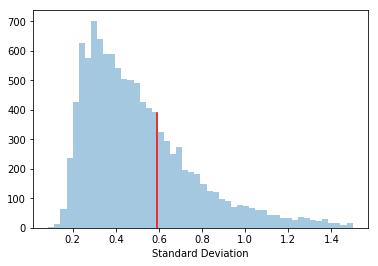

In [114]:
var_df = pd.DataFrame(sd_dict.items(), columns = ['Protein', 'Standard Deviation'])
var_df = var_df.dropna()

var_items = var_df['Standard Deviation']

filtered = var_items[(var_items >= 0) & (var_items < 1.5)]

varplot = sns.distplot(filtered, kde=False)
plt.axvline(0.5913397, 0,.53, color='red')
#varplot = sns.distplot(var_df['Variance'], kde=False)



In [110]:
sds = var_df['Standard Deviation']

median = np.median(sds)
minval = np.min(sds)
maxval = np.max(sds)
print("Median: ", median)
print("min: ", minval)
print("max: ", maxval)

Median:  0.45305672713335116
min:  0.08682253451725537
max:  3.0931007275553317


### Find min, max, and mean variances

In [8]:
variances = list(var_df['Variance'])
min_var = min(variances)
max_var = max(variances)
avg_var = np.mean(variances)

print("MIN: ", min_var)
print("MAX: ", max_var)
print("MEAN: ", avg_var)

MIN:  0.0075381525
MAX:  9.567272110803323
MEAN:  0.37193493622775325


In [9]:
from statsmodels.stats.power import TTestIndPower

In [10]:
from statsmodels.stats.power import TTestIndPower
analysis = TTestIndPower()
effect_size = analysis.solve_power(nobs1 = 50, power = .8, alpha = .05)
print(effect_size)

0.5658803032224228


In [11]:
# Low, medium, high
variances_low_med_high = [.0075, .37, 9.5]
sd = [0.08682253451, 0.61, 3.08]

detectable_diff = []
for standev in sd:
    detectable_diff.append(standev * effect_size)
    
print(detectable_diff)

[0.04913116215505806, 0.3451869849656779, 1.7429113339250621]


In [12]:
sorted_variances = sorted(variances)
length = len(sorted_variances)
print(length)
div_ten = length/10

dectiles = []
for i in range(0, 10):
    var_to_add = sorted_variances[int(0+(i*div_ten))]
    #print(var_to_add)
    dectiles.append(var_to_add)
#print(sorted_variances[len(sorted_variances)-1])
dectiles.append(sorted_variances[len(sorted_variances)-1])

print(dectiles)

10993
[0.0075381525, 0.05998126378937438, 0.08672422222222222, 0.1164725950610829, 0.1555542610483089, 0.2052603980007838, 0.26546381541039343, 0.3496826457638889, 0.48915157885543986, 0.7982087384544672, 9.567272110803323]


In [13]:
sd_dectiles = []
for vd in dectiles:
    sd_dectiles.append(np.sqrt(vd))

In [14]:
effect_sizes  = []
for i in range(10, 110, 10):
    analysis = TTestIndPower()

    effect_size = analysis.solve_power(nobs1 = i, power = .8, alpha = .05)

    print(effect_size)
    effect_sizes.append(effect_size)

1.3249473806412124
0.9091290568795594
0.7356198424871614
0.6342985155321065
0.5658803032224228
0.5157065039061857
0.47688182584131383
0.4456842248588056
0.4199048125342994
0.39813911739112756


### Determine the measurable difference value for each sample size (10-100) and dectile of variance.

In [15]:
all_vals = []
for i in range(0,len(effect_sizes)):
    effect_size_list = []
    for j in range(0,len(sd_dectiles)):
        effect_size_list.append(round(effect_sizes[i]*sd_dectiles[j], 5))
    all_vals.append(effect_size_list)
        
for es in all_vals:
    print(es)

[0.11504, 0.32449, 0.39018, 0.45218, 0.52256, 0.60028, 0.68266, 0.78349, 0.92666, 1.18374, 4.0982]
[0.07893, 0.22266, 0.26773, 0.31027, 0.35856, 0.41189, 0.46841, 0.5376, 0.63584, 0.81224, 2.81203]
[0.06387, 0.18016, 0.21663, 0.25105, 0.29013, 0.33328, 0.37901, 0.435, 0.51449, 0.65722, 2.27535]
[0.05507, 0.15535, 0.18679, 0.21647, 0.25017, 0.28737, 0.32681, 0.37509, 0.44362, 0.5667, 1.96195]
[0.04913, 0.13859, 0.16665, 0.19312, 0.22319, 0.25638, 0.29156, 0.33463, 0.39577, 0.50557, 1.75032]
[0.04477, 0.1263, 0.15187, 0.176, 0.2034, 0.23364, 0.26571, 0.30496, 0.36068, 0.46075, 1.59513]
[0.0414, 0.11679, 0.14044, 0.16275, 0.18808, 0.21605, 0.2457, 0.282, 0.33353, 0.42606, 1.47504]
[0.0387, 0.10915, 0.13125, 0.1521, 0.17578, 0.20192, 0.22963, 0.26355, 0.31171, 0.39819, 1.37855]
[0.03646, 0.10284, 0.12366, 0.14331, 0.16561, 0.19024, 0.21635, 0.24831, 0.29368, 0.37515, 1.29881]
[0.03457, 0.09751, 0.11725, 0.13588, 0.15703, 0.18038, 0.20513, 0.23544, 0.27846, 0.35571, 1.23148]


In [16]:
formatted = []

for row in all_vals:
    dectiles_row = []
    for entry_index in range(0, len(row)-1):
        dectiles_row.append(str(str(row[entry_index]) + " - " + str(row[entry_index + 1])))
    formatted.append(dectiles_row)
    
for f in formatted:
    print(f)

['0.11504 - 0.32449', '0.32449 - 0.39018', '0.39018 - 0.45218', '0.45218 - 0.52256', '0.52256 - 0.60028', '0.60028 - 0.68266', '0.68266 - 0.78349', '0.78349 - 0.92666', '0.92666 - 1.18374', '1.18374 - 4.0982']
['0.07893 - 0.22266', '0.22266 - 0.26773', '0.26773 - 0.31027', '0.31027 - 0.35856', '0.35856 - 0.41189', '0.41189 - 0.46841', '0.46841 - 0.5376', '0.5376 - 0.63584', '0.63584 - 0.81224', '0.81224 - 2.81203']
['0.06387 - 0.18016', '0.18016 - 0.21663', '0.21663 - 0.25105', '0.25105 - 0.29013', '0.29013 - 0.33328', '0.33328 - 0.37901', '0.37901 - 0.435', '0.435 - 0.51449', '0.51449 - 0.65722', '0.65722 - 2.27535']
['0.05507 - 0.15535', '0.15535 - 0.18679', '0.18679 - 0.21647', '0.21647 - 0.25017', '0.25017 - 0.28737', '0.28737 - 0.32681', '0.32681 - 0.37509', '0.37509 - 0.44362', '0.44362 - 0.5667', '0.5667 - 1.96195']
['0.04913 - 0.13859', '0.13859 - 0.16665', '0.16665 - 0.19312', '0.19312 - 0.22319', '0.22319 - 0.25638', '0.25638 - 0.29156', '0.29156 - 0.33463', '0.33463 - 0.3957

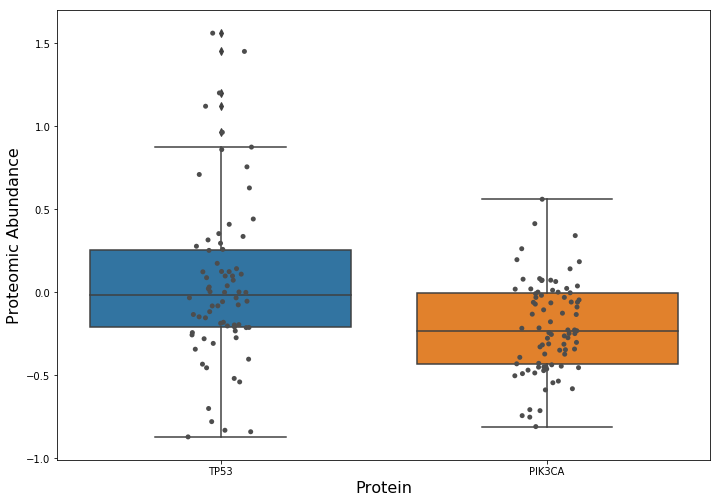

In [46]:
tp53_prot = endometrioid_df['TP53_proteomics']
pik3ca_prot = endometrioid_df['PIK3CA_proteomics']

plot_df1 = pd.DataFrame()
plot_df1['proteomic abundance'] = tp53_prot
plot_df1['protein'] = 'TP53'

plot_df2 = pd.DataFrame()
plot_df2['proteomic abundance'] = pik3ca_prot
plot_df2['protein'] = 'PIK3CA'

plot_df = pd.concat([plot_df1, plot_df2])

#print(tp53_prot)
#print("______")
#print(pik3ca_prot)

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = plot_df, y = 'proteomic abundance',x='protein', ax = ax)
boxplt = sns.stripplot(data = plot_df, y = 'proteomic abundance', x = 'protein', jitter = True, color = '.3')

ax.set_xlabel('Protein',fontsize=16)
ax.set_ylabel('Proteomic Abundance',fontsize=16)
#ax.plot(label='big')

#boxplt.set_title("Effect of " + gene + " mutation on SPRY1 proteomics in Endometrial Cancer" + '\nP-value = ' + str(pval), fontsize='16')

plt.show()

In [33]:
plot_df

,proteomic levels,protein
Sample_ID,,
S001,0.295000,TP53
S002,0.277000,TP53
S003,-0.871000,TP53
S005,-0.343000,TP53
S007,-0.148000,TP53
S008,0.441000,TP53
S010,-0.082500,TP53
S011,-0.181000,TP53
S012,-0.000425,TP53


In [47]:
from statsmodels.stats.power import TTestIndPower
analysis = TTestIndPower()
effect_size = analysis.solve_power(nobs1 = 50, power = .8, alpha = .05)

variance_of_mean_protein = 0.372
sd_of_mean_protein = np.sqrt(variance_of_mean_protein)

detectable_difference = effect_size * sd_of_mean_protein

print(detectable_difference)

0.34514059821750565


STAT:  -7.285084700973401
PVAL:  1.0250180625304501e-10


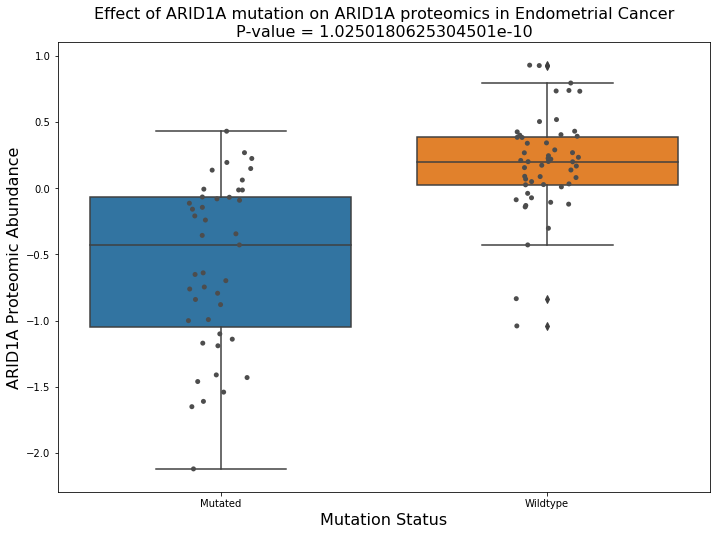

In [89]:
arid_df = en.join_omics_to_mutations(omics_df_name='proteomics', omics_genes='ARID1A', mutations_genes=['ARID1A'])
arid_df = arid_df.loc[arid_df['Sample_Status'] == 'Tumor']

for ind, row in arid_df.iterrows():
    if 'mutation' in row['ARID1A_Mutation_Status']:
        arid_df.at[ind,'Mutated'] = 'Mutated'
    else:
        arid_df.at[ind,'Mutated'] = 'Wildtype'
        
mutated = arid_df.loc[arid_df['Mutated'] == 'Mutated']
wt = arid_df.loc[arid_df['Mutated'] == 'Wildtype']

stat, pval  = scipy.stats.ttest_ind(mutated['ARID1A_proteomics'], wt['ARID1A_proteomics'])
print("STAT: ", stat)
print("PVAL: ", pval)

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = arid_df, y = 'ARID1A_proteomics',x='Mutated', ax = ax)
boxplt = sns.stripplot(data = arid_df, y = 'ARID1A_proteomics', x = 'Mutated', jitter = True, color = '.3')

boxplt.set_title("Effect of " + "ARID1A" + " mutation on ARID1A proteomics in Endometrial Cancer" + '\nP-value = ' + str(pval), fontsize='16')

ax.set_xlabel('Mutation Status',fontsize=16)
ax.set_ylabel('ARID1A Proteomic Abundance',fontsize=16)

plt.show()

In [90]:
mean1 = np.mean(mutated['ARID1A_proteomics'])
mean2 = np.mean(wt['ARID1A_proteomics'])

print(mean2-mean1)

0.7618441234347049


In [111]:
from statsmodels.stats.power import TTestIndPower
analysis = TTestIndPower()
effect_size = analysis.solve_power(nobs1=50, power=.8, alpha=.05)

sd_of_median_protein = 0.453

detectable_difference = effect_size * sd_of_median_protein

print(detectable_difference)

0.25634377735975755
